In [1]:
from carbon.helpers.stdimports import *
from carbon.helpers import j, strategy, pdread, pdcols, fsave, listdir, Params
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS

plt.rcParams['figure.figsize'] = [12,6]
plt_style('seaborn-v0_8-dark', 'seaborn-dark')
print_version(require="2.2.4")

[stdimports] imported np, pd, plt, os, sqrt, exp, log
Carbon v2.2.5-BETA0 (27/Jan/2022)
CarbonSimulatorUI v2.5 (25/Jan/2023)
CarbonOrderUI v1.6.1 (21/Jan/2023)


# Carbon Simulation - Demo 7-4 
_[frozen_20230127][frozen]: this notebook on [Binder][frozen_nb] and on [github][frozen_gh]_

Use **Run -- Run All Cells** in the menu above to run the notebook, then adjust the simulation parameters using the widgets provided. You can find **further usage instructions at the end of this notebook**, and throughout the notebook.

Further resources are (1) the github repo [github:carbon-simulator-binder][repob] associated with this binder, (2) the main simulator repo [github:carbon-simulator][repo], (3) the carbon package [pypi:carbon-simulator][simpypi] and finally (4) the ["Carbon Simulator" presentation][presn]

[presn]:https://github.com/bancorprotocol/carbon-simulator/blob/beta/resources/notes/202301%20Simulating%20Carbon.pdf
[simpypi]:https://pypi.org/project/carbon-simulator/
[repo]:https://github.com/bancorprotocol/carbon-simulator
[repob]:https://github.com/bancorprotocol/carbon-simulator-binder
[frozen]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230127
[frozen_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230127?labpath=Frozen%2FDemo7-4%2FDemo7-4.ipynb
[frozen_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/main/Frozen/Demo7-4/Demo7-4.ipynb

## Setup

In [2]:
# remove at next update
sim_params = SIM_DEFAULT_PARAMS.params
sim_params["plotValueCsh"] = True

### Type and destination of generated output

If `OUTPATH` is `None`, output will not be saved, otherwise it will be saved to the indicated directory (use `"."` for current)

In [3]:
try:
    outpath_w()
except:
    outpath_w = DropdownManager({
        "."                          : "Current",
        "/Users/skl/Desktop/sim7-4"  : "SKL Desktop/sim7-4", 
    },
    descr="Target", defaultix=0)
    outpath_w()

Dropdown(description='Target', options=(('Current', '.'), ('SKL Desktop/sim7-4', '/Users/skl/Desktop/sim7-4'))…

In [4]:
try:
    output_w()
except:
    output_w = CheckboxManager.from_idvdct(
        {f"Save output to target directory": True,
         f"Show target directory listing": True,
         f"Generate docx & zip from charts": True,
         f"Clear files before each run": False,
        })
    output_w()

### The source data collection (filename)
filename determines collection, eg `RAN-050-00` is sig=50% vol and mu=0% drift; see available collections in dropdown

In [5]:
DATAPATH = "../data"
try:
    datafn_w()
except:
    datafn_w = DropdownManager(listdir(DATAPATH, ".pickle"), defaultval="BTC-COINS")
    datafn_w()

Dropdown(options=(('BTC-COINS', 'BTC-COINS'), ('COS', 'COS'), ('RAN-005-00', 'RAN-005-00'), ('RAN-010-00', 'RA…

### The data columns within that data collection (scenarios)

Withing the collection there are multiple columns (up to 1000!). With the check boxes, you can choose from a specific subset of those colums. You can specify this subset setting `COL0` and `NCOLS`. The first `NCCOLS` are checked.

In [6]:
cols = tuple(pdcols(j(DATAPATH, f"{datafn_w.value}.pickle")))
try:
    assert datafn_w.value == old_datafn_w_value
    datacols_w(vertical=False)
except:
    old_datafn_w_value = datafn_w.value
    COL0, NCOLS, NCCOLS = 0, min(20, len(cols)), 4
    try:
        datacols_w = CheckboxManager(cols[COL0:COL0+NCOLS], values=NCCOLS*[True]+(NCOLS-NCCOLS)*[False])
    except:
        datacols_w = CheckboxManager(cols, values=[1,]+[0,]*(len(cols)-1))
    datacols_w(vertical=False)

### Strategies

This is the list of strategies to be tested against the paths. The first strategy is driven by the sliders below. The other strategies are hard-coded in the dict. The strategies `m1`, `m2` are strategy portfolios.

In [7]:
try:
    strats_w(vertical=False)
except:
    strats = {
         "slider":  None,
         "s1":      strategy.from_mgw(m=100, g=0.01, w=0.02, amt_rsk=1, amt_csh=0),
         "s2":      strategy.from_mgw(m=100, g=0.05, w=0.15, u=0.7, amt_rsk=1, amt_csh=0),
         "s3":      strategy(p_buy_a=80, p_buy_b=70, p_sell_a=110, p_sell_b=120, amt_rsk= 1, amt_csh=0),
         "m1":     [strategy.from_mgw(m=100, g=0.25, w=0.05, amt_rsk=1, amt_csh=0),
                    strategy.from_mgw(m=100, g=0.10, w=0.03, amt_rsk=1, amt_csh=0)],  
         "m2":     [strategy.from_mgw(m=100, g=0.10, w=0.1,  amt_rsk=1, amt_csh=0),
                    strategy.from_mgw(m=100, g=0.20, w=0.1,  amt_rsk=1, amt_csh=0)],  
         "uv3":     strategy.from_u3(p_lo=100, p_hi=150, start_below=True, fee_pc=0.05, tvl_csh=1000),
    }
    strats_w = CheckboxManager(strats.keys(), values=[1,0,0,0,0,0,0])
    #strats_w = CheckboxManager(strats.keys(), values=[1,0,0,0,0,0,0])
    #strats_w = CheckboxManager(strats.keys(), values=[0,0,0,0,0,0,1])
    strats_w(vertical=False)

The checkboxes above determined which strategies are tested, one by one.

### Elements to show on the chart

In [8]:
try: 
    params_w(vertical=False)
except:
    params_w = CheckboxManager.from_idvdct(sim_params)
    params_w(vertical=False)

### Time period

this is the time period that is plotted; periods and start dates are quoted as percentage total time; the window is cut at the left, eg start=0.9 and length=0.5 shows 0.9...1.0. Before the sliders are applied, everything before `PATH_MIN_DATE` is discarded. 

In [9]:
PATH_MIN_DATE = "2022-01-01"
try:
    segment_w(vertical=True)
except:
    segment_w = PcSliderManager(["Start date %", "Length %"], values=[0,1])
    segment_w(vertical=True)

### The `slider` strategy

This is the strategy called `slider`. Here `m` is the mid price of the range (adjust `S0`, `SMIN`, `SMAX` to change), `g%` is the gap between the ranges in percent, and `w%` is the width of the ranges in percent. The parameter `u%` is the range utilisation rate, where `u=0%` means the range is full, and `u~100%` means that it is almost empty. The parameter `csh:rsk` is the initial cash ratio (where 0% means all rsk, 100% all csh, and 50% even split). Total cash value of the initial portfolio is `TVL`.

In [10]:
try:
    strat1_w(vertical=True)
except:
    S0, SMIN, SMAX, TVL = 100, 50, 150, 1000
    strat1_w = PcSliderManager(["m", "g%", "w%", "u%", "csh:rsk"], 
                        values=[S0/100, 0.1, 0.25, 0, 0.5], 
                        range=[(SMIN/100,SMAX/100),(0,0.25),(0,0.25),(0,1),(0,1)])
    strat1_w(vertical=True)

## Simulation

In [11]:
if output_w.values[3]:
    print("CLEARING OUT PREVIOUS FILES [UNCHECK BOX ABOVE TO DISABLE]")
    !rm {OUTPATH}/*.png
    !rm {OUTPATH}/_CHARTS.zip
    !rm {OUTPATH}/_CHARTS.md
    !rm {OUTPATH}/_CHARTS.docx

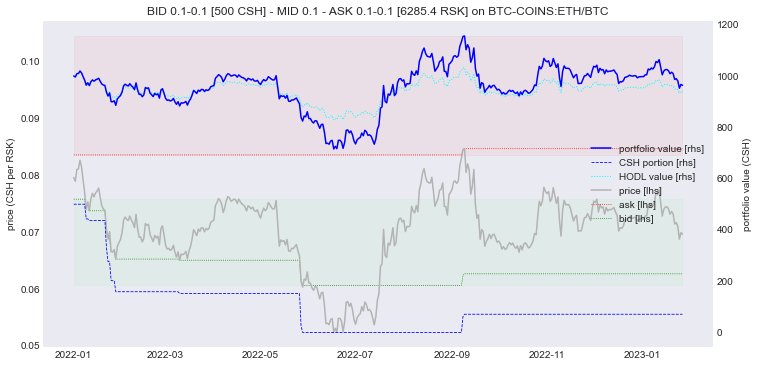

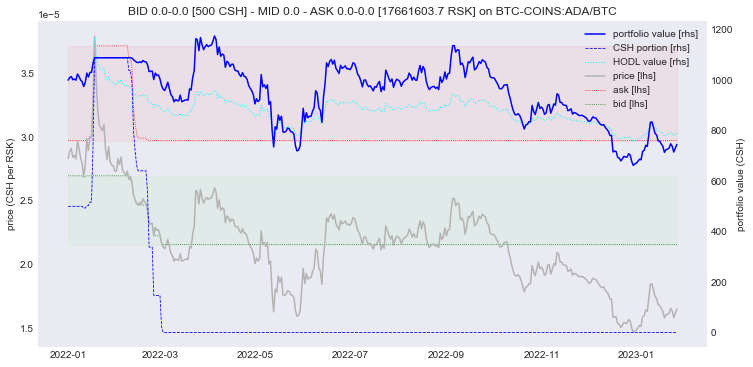

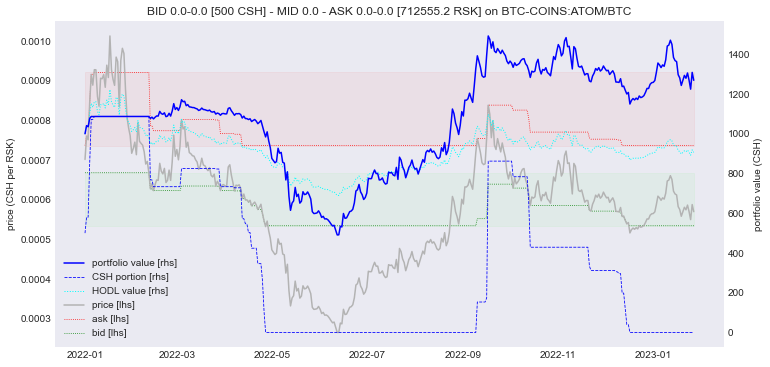

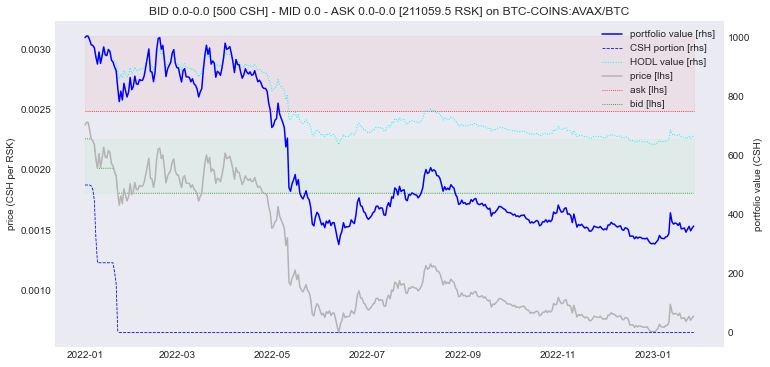

In [12]:
DATAID, DATAFN = datafn_w.value, j(DATAPATH, f"{datafn_w.value}.pickle") 
OUTPATH = outpath_w.value if output_w.values[0] else None
STARTPC, LENPC, SV = segment_w.values[0], segment_w.values[1], strat1_w.values
for colnm in datacols_w.checked:
    path = pdread(DATAFN, colnm, from_pc=STARTPC, period_pc=LENPC, min_dt=PATH_MIN_DATE)
    strats["slider"] = strategy.from_mgw(m=100*SV[0], g=SV[1], w=SV[2], u=SV[3], amt_rsk=TVL/path[0]*(1-SV[4]), amt_csh=TVL*SV[4])
    for ix, stratid in enumerate(strats_w.checked):
        strat = strats[stratid]
        simresults = run_sim(strat, path)
        plot_sim(simresults, f"{DATAID}:{colnm}", Params(**params_w.values_dct))
        if isinstance(OUTPATH, str):
            plt.savefig(j(OUTPATH, f"{DATAID}-{colnm.replace('/', '')}-{ix}-{STARTPC*100:.0f}-{LENPC*100:.0f}.png"))
        plt.show()

Provide the corresponding box above (_"Show target directory listing"_) is checked, this will create a list of all `png` files generated throughout your analysis. Those files will only be generated is the box _"Save output to target directory"_ box is checked. The target directory is preset to the directory of this notebook, but you can change this in the code above. Keep in minds that if you run this analysis **on Binder, you have to download all files you want to keep before the server is destroyed.**

In [13]:
if OUTPATH and output_w.values[1]:
    print("Listing OUTPATH [uncheck box at top to disable]")
    print ([fn[:-4] for fn in os.listdir(OUTPATH) if fn[-4:]==".png"])

Listing OUTPATH [uncheck box at top to disable]
['BTC-COINS-ETHBTC-1-0-100', 'BTC-COINS-ETHBTC-0-0-100', 'BTC-COINS-ADABTC-0-0-100', 'BTC-COINS-ATOMBTC-0-0-100', 'BTC-COINS-AVAXBTC-0-0-100', 'BTC-COINS-ADABTC-1-0-100', 'BTC-COINS-ATOMBTC-1-0-100']


Provide the corresponding box above (_"Generate docx & zip from charts"_) is checked, this code will create a Word `docx` file embedding all the `png` files in this folder. You can simply download this file via the Jupyter Lab interface to have all charts together in one convenient place. You can then extract them at a later stage from the `docx` files for example via copy and paste. The files will also all be consolidated into a single zip file.

In [14]:
if OUTPATH and output_w.values[2]:
    print("Creating consolidated docx and zip from charts [uncheck box at top to disable]")
    filelist = os.listdir(OUTPATH)
    filelist = [fn for fn in filelist if fn[-4:]==".png"]
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in filelist)
    fsave(markdown, "_CHARTS.md", OUTPATH)
    !pandoc {OUTPATH}/_CHARTS.md -o {OUTPATH}/_CHARTS.docx
    !zip _CHARTS.zip *.png 
    print("---")
    !ls

Creating consolidated docx and zip from charts [uncheck box at top to disable]
[fsave] Writing _CHARTS.md to .
updating: BTC-COINS-ADABTC-0-0-100.png (deflated 3%)
updating: BTC-COINS-ADABTC-1-0-100.png (deflated 3%)
updating: BTC-COINS-ATOMBTC-0-0-100.png (deflated 3%)
updating: BTC-COINS-ATOMBTC-1-0-100.png (deflated 3%)
updating: BTC-COINS-ETHBTC-0-0-100.png (deflated 3%)
updating: BTC-COINS-ETHBTC-1-0-100.png (deflated 3%)
updating: BTC-COINS-AVAXBTC-0-0-100.png (deflated 4%)
---
BTC-COINS-ADABTC-0-0-100.png  Demo7-4.ipynb
BTC-COINS-ADABTC-1-0-100.png  Demo7-4.py
BTC-COINS-ATOMBTC-0-0-100.png _CHARTS.docx
BTC-COINS-ATOMBTC-1-0-100.png _CHARTS.md
BTC-COINS-AVAXBTC-0-0-100.png _CHARTS.zip
BTC-COINS-ETHBTC-0-0-100.png  carbon
BTC-COINS-ETHBTC-1-0-100.png


## Usage instructions

### Installation

This notebook should run straight out of the box at the Binder URL provided above. Alternatively you can download it locally and make sure `carbon-simulator` and the dependencies in `requirements.txt` are installed. You can install `carbon-simulator` [via pypi](https://pypi.org/project/carbon-simulator/). Alternatively, you can download the simulator [from github](https://github.com/bancorprotocol/carbon-simulator-binder) and then place this notebook in the root directory of the repo, or any other directory on your system that contains a `carbon` directory symlinked to the `carbon` directory in the repo.


### Parameter updates

This notebook is controlled with a combination of code-based parameter pre-sets, and UI-driven choices using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/stable/). You can usually refresh the simulation by running the cell generating the simulation output, but recommended procedure is a **Run All Cells** after every change. There is one gotcha, and its TLDR is: **If you run into a problem after changing parameters, restart the kernel and Run All again**. The longer version is as follows:


The widgets all appear in codeblocks of this style:

    try:
        segment_w(vertical=True)
    except:
        segment_w = PcSliderManager(["Start date %", "Length %"], values=[0,1])
        segment_w(vertical=True)
        
 
The reason is as follows: the `segment_w = ...` statement recreates the widget at every run, which mean it will lose state at every run, which breaks our workflow. The statement `segment_w(...)` only displays the widget, which means it is safe to run repeatedly, without losing state. Therefore at every run, we try to run the widget. This will fail at the first run, so the initialization code in the except-block is executed. Subsequent runs then no longer touch that initialization code, as then the try-block succeeds.

Herein lies the problem: once a widget has been created, changes to the initialization code won't take effect unless the try-block fails, hence the **Restart kernel and run all** procedure above. This however leads you to lose state in _all_ widgets. If you want to avoid this, you can make the specific try-block fail, eg by temporarily renaming the function to `segment_w1(...)` and changing it back once the initializations work properly.

### JupyText `.py` file

This notebook is set up for [JupyText](https://jupytext.readthedocs.io/en/latest/) which, when installed, tracks the notebook code in a `.py` file with the same base name as the notebook. If you have JupyText installed (which is not the case on Binder) then you can open either the `.py` or the `.ipynb` file, they will both open the same notebook, and the two files will be kept in synch. 

For practical work on Binder you can ignore the `.py` file. However, its diffs -- if available -- are more meaningful than the diffs on the `.ipynb` file where most of the changes you'll see will related to changes in outputs, many of them spurious. 